# The Random Forest Algorithm

The random forest algorithm is a machine learning method that joins multiple decision tree instances to perform classification or regression. Such combinations are known as ensemble learning models. The term 'random forest' is derived from the inverted forest-like appearance of a multiple decision trees joined at the head.

Here we will demonstrate an implementation of both regression (making a prediction based on continuuous data - essentially fancy fitting) and classification (predicting labels of objects based on past experience). Both methods are types of supervised learning, where we train the algorithm on example data.

First we need to understand the basics - the decision tree.

## 1. Decision Trees

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

We can think of a DT as a series of sequential yes/no questions like a flowchart. The final result of the tree is a class label (classification) or value (regression).

<img src="Images/simple_dtree.png">

A decision tree model is trained and built by determing the questions that lead to the 'best result'. In pracise the best result is determined by the greatest reduction in the *Gini Impurity*. This is simply a measurement of the likelihood of an incorrect classification of a new instance of a random variable - 0 is perfect classification.

## 1.1 A toy example

We start with a very simple example - binary classification in 2D. This is where we can plot two classes of object on a 2D scatter plot, where the x- and y-axis are the features that describe the data. Traditionally in the ML world denote the features as an array *X* and the as a vector *y*.

#### Create and plot simple data

In [1]:
import numpy as np

# 2D Array of features [x1, x2]
X = np.array([[2, 2], 
              [2, 1],
              [2, 3], 
              [1, 2], 
              [1, 1],
              [3, 3]])

# Labels each point as belonging to one of two classes
y = np.array([0, 1, 1, 1, 0, 1])

It is easier to understand the data if we visualise it in 2D:

Text(0.5,1,'Data')

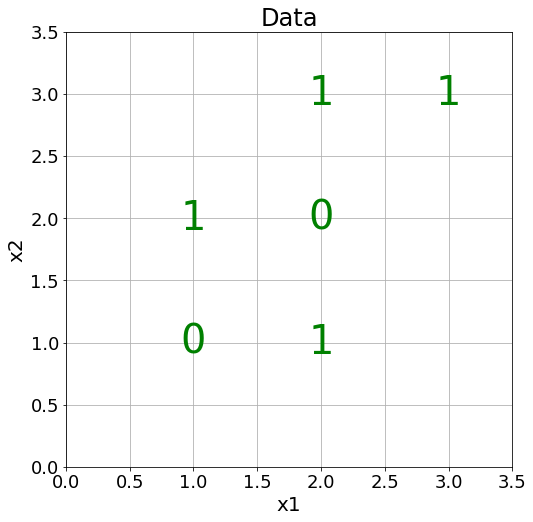

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot formatting
plt.rcParams['font.size'] = 18
plt.figure(figsize = (8, 8))

# Plot each point as the label
for x1, x2, label in zip(X[:, 0], X[:, 1], y):
    plt.text(x1, x2, str(label), fontsize = 40, color = 'g',
             ha='center', va='center')
    
# Plot formatting
plt.grid(None);
plt.xlim((0, 3.5));
plt.ylim((0, 3.5));
plt.xlabel('x1', size = 20); plt.ylabel('x2', size = 20); plt.title('Data', size = 24)

You can see from this plot the the two classes are not separable by a single straight line. This means that a simple linear classifier will not work. A decision tree works because it draws many boundaries between the points.

We will use a single decision tree to learn how to separate the points. As the tree builds, the algorithm makes branches by maximising the *reduction* in Gini impurity.

The default parameters of the scikit-learn decision tree allow it to grow to an arbritrary depth in order to correctly classify all the data. This is essentially menorising the data and leads to overfitting. In real problems we would limit the depth.

#### Run the decision tree algorithm

In [3]:
# Import the decision tree algorithm from scikit-learn
from sklearn.tree import DecisionTreeClassifier

# Create an instance of the decision tree with default parameters
tree = DecisionTreeClassifier(random_state=42)

# Train the tree on the simple data
tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [4]:
# Print some stats
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')
print(f'Model Accuracy: {tree.score(X, y)}')

Decision tree has 9 nodes with maximum depth 3.
Model Accuracy: 1.0


#### Visualize the decision tree

We can plot the decision tree as a flowchart to show each node in the tree. Because the tree is relatively small, we can understand the entire image.

First we export the tree as a dot file making sure to label the features and the classes.

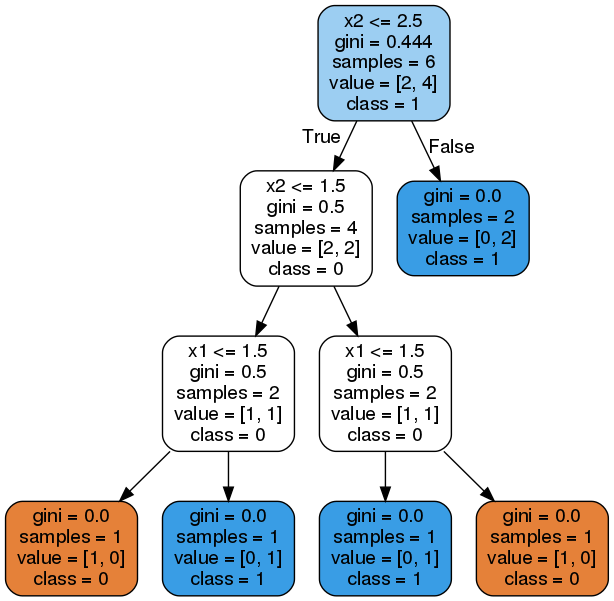

In [5]:
from sklearn.tree import export_graphviz

# First export as dot file
export_graphviz(tree, 'TMP/tree.dot', rounded = True, 
                feature_names = ['x1', 'x2'], 
                class_names = ['0', '1'], filled = True)

# Then use a system command to convert to a PNG
!dot -Tpng TMP/tree.dot -o TMP/tree.png -Gdpi=100

# Display the image
from IPython.display import Image
Image('TMP/tree.png')

Then we use a system command to create a PNG image to display

A decision tree is an intuitive model: it makes decisions much as we might when faced with a problem by constructing a flowchart of questions. For each of the nodes (except the leaf nodes), the five rows represent:

 * The node question

 * gini: the Gini Impurity of the node. The average (weighted by samples) gini impurity decreases with each level of the tree.
 * samples: number of training observations in the node
 * value: [number of samples in the first class, number of samples in the second class]
 * class: the predicted class at this levelp
 

#### Run again with limited depth

In practice, we usually want to limit the maximum depth of the decision tree (even in a random forest) so the tree can generalize better to testing data. Although this will lead to reduced accuracy on the training data, it can improve performance on the testing data.

In [6]:
# Limit maximum depth and train
short_tree = DecisionTreeClassifier(max_depth = 2, random_state=42)
short_tree.fit(X, y)

print(f'Model Accuracy: {short_tree.score(X, y)}')

Model Accuracy: 0.6666666666666666


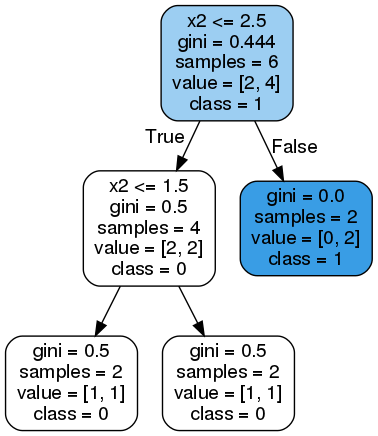

In [7]:
# Export as dot
export_graphviz(short_tree, 'TMP/shorttree.dot', rounded = True, 
                feature_names = ['x1', 'x2'], 
                class_names = ['0', '1'], filled = True)

# Convert to PNG and display
!dot -Tpng TMP/shorttree.dot -o TMP/shorttree.png -Gdpi=100
Image('TMP/shorttree.png')

Our model no longer gets perfect accuracy on the training data. However, it probably would do better on the testing data since we have limited the maximum depth to prevent overfitting.

Limiting the depth of a single decision tree is one way we can try to make a less biased model. Another option is to use an entire forest of trees, training each one on a random subsample of the training data. The final model then takes an average of all the individual decision trees to arrive at a classification. This is the idea behind the random forest.
<img src="Images/Random_forest_diagram_complete.png">



## 1.2 A real example - predicting health

The following data set is from the Centers for Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals. The objective is to predict the overall health of an individual: either 0 for poor health or 1 for good health. We'll limit the data to 100,000 individuals to speed up training.

The problem is imbalanced (far more of one label than another) so for assessing performance, we'll use recall, precision, receiver operating characteristic area under the curve (ROC AUC), and also plot the ROC curve. Accuracy is not a useful metric when dealing with an imbalanced problem.


#### Load the data and clean

First step is to load the data into a Pandas *dataframe* and clean any errant values. (A dataframe is a container for tabular data similar to a spreadsheet).

In [8]:
import pandas as pd

# Read the data into a dataframe
df = pd.read_csv('DATA/2015_health_50k.csv')
print("Dimensions of data [rows, columns]:", df.shape)
df.head()

Dimensions of data [rows, columns]: (50000, 331)


Unnamed: 0  _STATE  FMONTH        IDATE IMONTH   IDAY    IYEAR  DISPCODE  \
0      223424    30.0     2.0  b'02042015'  b'02'  b'04'  b'2015'    1100.0   
1      373769    48.0    12.0  b'12172015'  b'12'  b'17'  b'2015'    1100.0   
2      155460    23.0     9.0  b'09092015'  b'09'  b'09'  b'2015'    1100.0   
3      231267    31.0     8.0  b'08312015'  b'08'  b'31'  b'2015'    1100.0   
4      133471    20.0     2.0  b'02222015'  b'02'  b'22'  b'2015'    1200.0   

          SEQNO          _PSU  ...  _PAREC1  _PASTAE1  _LMTACT1  _LMTWRK1  \
0  2.015001e+09  2.015001e+09  ...      3.0       2.0       3.0       3.0   
1  2.015014e+09  2.015014e+09  ...      4.0       2.0       3.0       3.0   
2  2.015003e+09  2.015003e+09  ...      4.0       2.0       2.0       2.0   
3  2.015003e+09  2.015003e+09  ...      2.0       2.0       3.0       3.0   
4  2.015018e+09  2.015018e+09  ...      9.0       9.0       NaN       NaN   

   _LMTSCL1  _RFSEAT2  _RFSEAT3  _FLSHOT6  _PNEUMO2  _AIDTST3  
0       4.0       1.0       1.0       NaN       NaN       1.0  
1       4.0       1.0       1.0       NaN       NaN       1.0  
2       3.0       1.0       1.0       1.0       9.0       1.0  
3       4.0       1.0       1.0       NaN       NaN       1.0  
4       NaN       9.0       9.0       NaN       NaN       NaN  

[5 rows x 331 columns]

In [10]:
# Select only columns that contain numbers
df = df.select_dtypes('number')
print("Dimensions of data [rows, columns]:", df.shape)
df.head()

Dimensions of data [rows, columns]: (50000, 324)


Unnamed: 0  _STATE  FMONTH  DISPCODE         SEQNO          _PSU  CTELENUM  \
0      223424    30.0     2.0    1100.0  2.015001e+09  2.015001e+09       1.0   
1      373769    48.0    12.0    1100.0  2.015014e+09  2.015014e+09       NaN   
2      155460    23.0     9.0    1100.0  2.015003e+09  2.015003e+09       1.0   
3      231267    31.0     8.0    1100.0  2.015003e+09  2.015003e+09       1.0   
4      133471    20.0     2.0    1200.0  2.015018e+09  2.015018e+09       NaN   

   PVTRESD1  COLGHOUS  STATERES  ...  _PAREC1  _PASTAE1  _LMTACT1  _LMTWRK1  \
0       1.0       NaN       1.0  ...      3.0       2.0       3.0       3.0   
1       NaN       NaN       NaN  ...      4.0       2.0       3.0       3.0   
2       1.0       NaN       1.0  ...      4.0       2.0       2.0       2.0   
3       1.0       NaN       1.0  ...      2.0       2.0       3.0       3.0   
4       NaN       NaN       NaN  ...      9.0       9.0       NaN       NaN   

   _LMTSCL1  _RFSEAT2  _RFSEAT3  _FLSHOT6  _PNEUMO2  _AIDTST3  
0       4.0       1.0       1.0       NaN       NaN       1.0  
1       4.0       1.0       1.0       NaN       NaN       1.0  
2       3.0       1.0       1.0       1.0       9.0       1.0  
3       4.0       1.0       1.0       NaN       NaN       1.0  
4       NaN       9.0       9.0       NaN       NaN       NaN  

[5 rows x 324 columns]

The column '_RFHLTH' gives the ground-truth for health. However, we want to replace values of 2 or above with 0

In [11]:
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})

In [12]:
# Select for only data with labels in range [0, 1]
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()

# Rename the column as 'label'
df = df.rename(columns = {'_RFHLTH': 'label'})

# How many of each value 0, 1
df['label'].value_counts()

1.0    40453
0.0     9406
Name: label, dtype: int64

There are far more rows with label '1' than '0': this is an imbalanced dataset. In such a dataset we don't want to use accuracy as a metric.

In [13]:
# Remove columns with missing values
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])

#### Split into train and test set

In supervised learning we want to set aside some data as an 'independent' dataset to test our predictions. This is usually some randomly-chosen fraction of the input data. Scikit-learn has a convenience function to make this split easy:

In [14]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = 42)
print("Train data shape:", train.shape)
print("Test data shape:", test.shape)

Train data shape: (34901, 314)
Test data shape: (14958, 314)


In [15]:
# Fill in missing values with mean of test 
train = train.fillna(train.mean())
test = test.fillna(test.mean())

In [16]:
# Grab the list of column names
features = list(train.columns)

#### Decision Tree on Real Data

First, we'll train the decision tree on the data. Let's leave the depth unlimited and see if we get overfitting!

In [17]:
# Train tree
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 6443 nodes with maximum depth 48.


#### Assess Decision Tree Performance

Given the number of nodes in our decision tree and the maximum depth, we expect it has overfit to the training data. This means it will do much better on the training data than on the testing data.

In [18]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [19]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.6420714947112504


In [20]:
print(f'Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')


Baseline ROC AUC: 0.5


#### Evaluate the Decision Tree

We'll write a short function that calculates a number of metrics for the baseline (guessing the most common label in the training data), the testing predictions, and the training predictions. The function also plots the ROC curve where a better model is to the left and towards the top.

In [21]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [22]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

Counter({1.0: 11362, 0.0: 3596})
Counter({1.0: 11362, 0.0: 3596})


Recall Baseline: 1.0 Test: 0.81 Train: 1.0
Precision Baseline: 0.81 Test: 0.87 Train: 1.0
Roc Baseline: 0.5 Test: 0.64 Train: 1.0


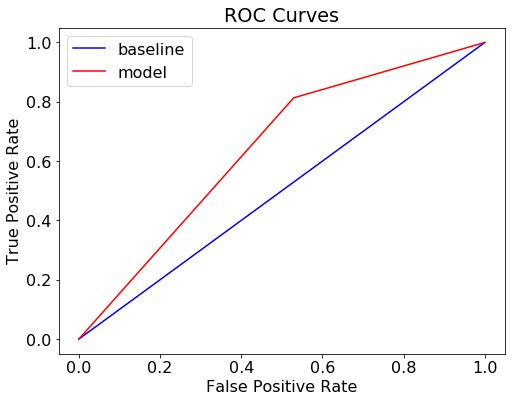

In [23]:
evaluate_model(predictions, probs, train_predictions, train_probs)

There we can see the problem with a single decision tree where the maximum depth is not limited: severe overfitting to the training data.

Another method to inspect the performance of a classification model is by making a confusion matrix.

#### Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
#    plt.grid(None)
#    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[1329 1493]
 [2267 9869]]


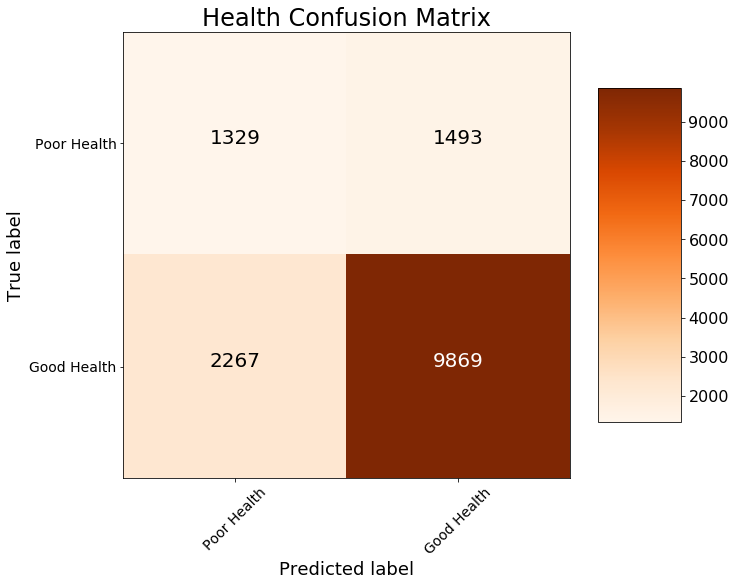

In [25]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

This shows the classifications predicted by the model on the test data along with the real labels. We can see that our model has many false negatives (predicted good health but actually poor health) and false positives (predicted poor health but actually good health).

#### Feature Importances
Finally, we can take a look at the features considered most important by the Decision Tree. The values are computed by summing the reduction in Gini Impurity over all of the nodes of the tree in which the feature is used.

In [26]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

feature  importance
63   DIFFWALK    0.184392
59   QLACTLM2    0.033830
52    EMPLOY1    0.029914
55   INTERNET    0.016315
246     _BMI5    0.014925

### Visualize Full Tree

As before, we can look at the decision tree on the data. This time, we have to limit the maximum depth otherwise the tree will be too large and cannot be converted and displayed as an image.

In [28]:
# Save tree as dot file
export_graphviz(tree, 'TMP/tree_real_data.dot', rounded = True, 
                feature_names = features, max_depth = 6,
                class_names = ['poor health', 'good health'], filled = True)

# Convert to png
!dot -Tpng TMP/tree_real_data.dot -o TMP/tree_real_data.png -Gdpi=200

# Visualize
Image(filename='TMP/tree_real_data.png')

We can see that our model is extremely deep and has many nodes. To reduce the variance of our model, we could limit the maximum depth or the number of leaf nodes. Another method to reduce the variance is to use more trees, each one trained on a random sampling of the observations. This is where the random forest comes into play.

## 2. Random Forest

This takes the idea of a single decision tree, and creates an ensemble model out of hundreds or thousands of trees to reduce the variance. Each tree is trained on a random set of the observations, and for each split of a node, only a subset of the features are used for making a split. When making predictions, the random forest averages the predictions for each of the individual decision trees for each data point in order to arrive at a final classification.

### 2.1 Random Forest with fixed parameters

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=42, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

/home/cpurcell/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=1, warm_start=False)

We can see how many nodes there are for each tree on average and the maximum depth of each tree. There were 100 trees in the forest.

In [30]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 6821
Average maximum depth 40


#### Results


In [31]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 1.0


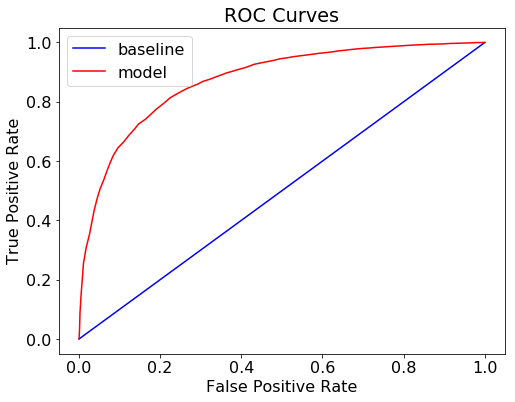

In [32]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)


Confusion matrix, without normalization
[[ 1283  1539]
 [  545 11591]]


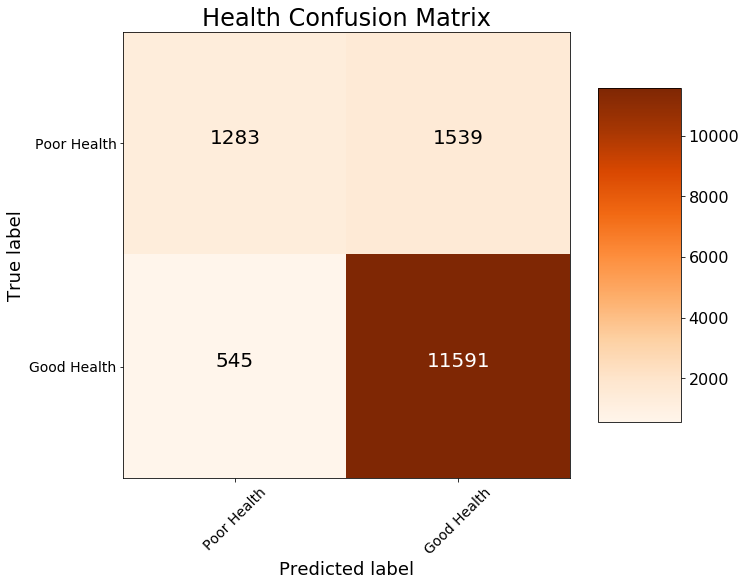

In [33]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

Compared to the single decision tree, the model has fewer false postives although more false negatives. Overall, the random forest does significantly better than a single decision tree. This is what we expected!